# 全局配置

In [2]:
import os
from torch import nn
import torch
import models

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 屏蔽GPU
os.sys.path.append(r'F:\work\jupyter\Transfer Learning')
from tools import mmd
from tools import torch_plot
from tools import load
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 文件路径等
root = r'F:\凯斯西储大学数据'
frequency = '12K'
classes = ('滚动体故障', '内圈故障', '外圈故障', '正常')
where = '风扇端'
source = '0HP'
target = '1HP'
batch_size = 32

# 加载数据

In [20]:
source_train = load.load_source(root, frequency, classes, source, where)
target_train, target_test = load.load_target(root, frequency, classes, target, where)

# 训练网络

In [18]:
def train(source, target, model, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # 优化器
    
    len_dataloader = min(len(source), len(target))
    
    size_source = len(source.dataset)    # 源域的样本总量
    num_batches_source = len(source)            # 源域的批数
    num_batches_target = len(target)            # 目标域的批数
    
    # 定义损失函数
    loss_fn_classification = nn.CrossEntropyLoss(reduction='mean')     # 分类损失函数
    loss_fn_dicriminate = nn.CrossEntropyLoss(reduction='mean') # 领域鉴别损失

    # 训练
    model.train()
    train_loss, correct, total_discriminate_loss = 0., 0., 0.
    
    # ------------------源域------------------
    for batch, (data, y) in enumerate(source):
        data, y = data.to(device), y.to(device)
        # -----前向传播以及损失计算-----
        classify_output, domain_output = model(data)
        
        classify_loss = loss_fn_classification(classify_output, y)       # 分类损失
        domain_label = torch.ones(batch_size).to(torch.long)
        domain_label = domain_label.to(device)    # 域标签，源域类别记为1
        discriminate_loss = loss_fn_dicriminate(domain_output, domain_label)  # 域鉴别损失
        loss = classify_loss + discriminate_loss      # 总的损失
        
        total_discriminate_loss += discriminate_loss.item()
        train_loss += loss.item()

        # -------计算分类正确的个数-------
        correct += (classify_output.argmax(1) == y).type(torch.float).sum().item() 
        
        # ------------------反向传播------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"[Source] loss: {loss:>7f}  [{current:>5d}/{size_source:>5d}]")
            
    train_loss /= num_batches_source   # 计算训练损失
    correct /= size_source             # 分类正确率
    
    # -----------------目标域----------------- 
    temp_dicriminate_loss = 0.    # 用于保存损失，因为源域和目标域的batch数不一样，所以用两个变量来保存
    for batch, (data, y) in enumerate(target):
        data, y = data.to(device), y.to(device)
        # -----前向传播以及损失计算-----
        _, domain_output = model(data)
        domain_label = torch.zeros(batch_size).to(torch.long)
        domain_label = domain_label.to(device)    # 域标签，源域类别记为1
        loss = loss_fn_dicriminate(domain_output, domain_label) # 目标域类别记为0
        
        temp_dicriminate_loss += discriminate_loss.item()

        # ------------------反向传播------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"[Target] loss: {loss:>7f}  [{current:>5d}/{size_source:>5d}]")
    temp_dicriminate_loss /= num_batches_target
    
    # -----------总的损失------------- 
    train_loss += temp_dicriminate_loss                # 总的训练损失
    total_discriminate_loss += temp_dicriminate_loss   # 领域鉴别损失
    
    return train_loss, correct, total_discriminate_loss


def test(dataloader, model):
    loss_fn = nn.CrossEntropyLoss()     # 分类损失函数
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, discriminate_loss = 0., 0., 0.

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            classify_output, _ = model(X, y)
            classification_loss = loss_fn(classify_output, y)      # 分类损失
            test_loss += classification_loss.item()
            correct += (classify_output.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [ ]:
model = models.DaNN().to(device)
    
epochs = 50

train_losses = []
train_accs = []
train_d_losses = []

test_losses = []
test_accs = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc, train_d_loss = train(source_train, target_train, model, lr=1e-4)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_d_losses.append(train_d_loss)

    # 测试模型
    test_loss, test_acc = test(target_test, model)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

print("Done!")

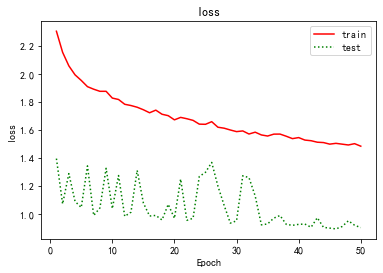

In [23]:
torch_plot.plot(train_losses, test_losses, dtype='loss')

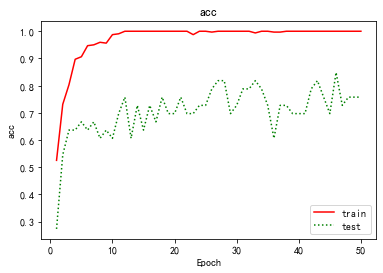

In [24]:
torch_plot.plot(train_accs, test_accs)